# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [149]:
# import libraries
# General Utilities for Web Scraping
import re
import sys
import os
from os import listdir
from os.path import isfile, join, isdir
import requests
import urllib.request
import time
from bs4 import BeautifulSoup
from tqdm import tqdm
from datetime import date, datetime
from dateutil import relativedelta
import csv
import json
import collections
from collections import defaultdict
from collections import Counter

# Machine Learning Utitilies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import seaborn as sns

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.metrics import silhouette_score, mean_squared_error, silhouette_samples, pairwise_distances_argmin_min
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# Pyspark
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    udf, 
    desc, 
    asc, 
    sum as Fsum,
    lag,
    row_number,
    col,
    count,
    when
)
from pyspark.sql.types import StringType, IntegerType

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1563942846532'),
 ('spark.app.name', 'Sparkify'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '53121'),
 ('spark.driver.host', 'chengyis-mbp'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_user_log.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
path = "./data/mini_sparkify_event_data.json"
user_log = spark.read.json(path)
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
user_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [7]:
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [8]:
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
# # If you need to save it into csv
# out_path = "./data/mini_sparkify_event_data.csv"
# user_log.write.save(out_path, format='csv', header=True)

In [10]:
user_log.describe("length").show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783478|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



In [11]:
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [12]:
user_log.describe("userId").show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910604|
|    min|                  |
|    max|                99|
+-------+------------------+



In [13]:
user_log.select(["userId", "firstName", "page", "song"]) \
    .where(user_log.userId == "99") \
    .collect()[:10]

[Row(userId='99', firstName='Madison', page='Home', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Welcome (Album Version)'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Si No Existo (Live)'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Moments with Oliver'),
 Row(userId='99', firstName='Madison', page='NextSong', song='Si Do Mhaimeo I'),
 Row(userId='99', firstName='Madison', page='Thumbs Down', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Coleccionista De Canciones'),
 Row(userId='99', firstName='Madison', page='Roll Advert', song=None),
 Row(userId='99', firstName='Madison', page='NextSong', song='Opposite Of Adults'),
 Row(userId='99', firstName='Madison', page='Thumbs Up', song=None)]

Let's find how many songs a user listens to in an hour.

In [14]:
# Spark User-defined Function toget hours from timestamp
get_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour)

# Convert ts column to hours
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='8')

See that Colin listened to Rockpools at 8am. We'll now group the songs by the hour to determine how many songs was listened to in each  hour by each user.

In [15]:
songs_in_hour = user_log.filter(
    user_log.page == "NextSong"
).groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0|11636|
|   1|11460|
|   2|11124|
|   3|10930|
|   4|10856|
|   5|10458|
|   6|10122|
|   7| 9630|
|   8| 9062|
|   9| 8388|
|  10| 8336|
|  11| 8355|
|  12| 8147|
|  13| 8178|
|  14| 8054|
|  15| 8091|
|  16| 8253|
|  17| 8498|
|  18| 8882|
|  19| 8830|
+----+-----+
only showing top 20 rows



In [ ]:
songs_in_hour_pd = songs_in_hour.toPandas()

fig, ax = plt.subplots(1,1)
ax.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
ax.set_xlabel("Hour")
ax.set_ylabel("Songs Played")
ax.set_title("Songs Played Vs. Hour")
ax.grid()
plt.show();

In [19]:
user_log_valid = user_log.dropna(how='any', subset=["userId", "sessionId"])
user_log_valid.count()

286500

In [21]:
user_log_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



Weird, there is an empty string as the `userId`, let's remove all the `userId`s with an empty string and count again.

In [23]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")
user_log_valid.count()

278154

This way, we've only included `userId`s that have a valid value.

We also want to distinguish a user's activity before and after a particular event such as `Submit Downgrade`.

In [27]:
# Find all users that have downgraded their service
user_log_valid.filter("page = 'Submit Downgrade'").show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|hour|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+----+
|  null|Logged In|     Kael|     M|           47|   Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|  19|
|  null|Logged In|   Calvin|     M|           17|Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38|   5|


Let's take a look at Kael's activity to understand why he downgraded his plan.

In [225]:
kael_log = user_log_valid.select([
        "userId", 
        "sessionId",
        "firstName", 
        "page", 
        "level", 
        "hour"]) \
    .where(user_log_valid.userId == "131") \
    .withColumn("row_num", 
                row_number().over(Window.partitionBy().orderBy("userId"))) \
    .withColumn("prev_hour",
                lag(user_log_valid.hour.cast("float"), count=1).over(Window.partitionBy().orderBy("row_num"))) \
    .fillna(1.0) \
    .withColumn("change_hour_row_num", (col("hour") != col("prev_hour")).cast("float") * col("row_num")) \
    .filter(col("change_hour_row_num") != 0.0) \
    .withColumn("change_hour_row_num_prev",
                lag(col("change_hour_row_num").cast("float"), count=1).over(Window.partitionBy().orderBy("row_num"))) \
    .fillna(0.0) \
    .withColumn("total_songs_per_hour", 
                lag(col("change_hour_row_num") - col("change_hour_row_num_prev"), count=-1).over(Window.partitionBy().orderBy("row_num"))) \
    .fillna(1.0) \
    .drop("prev_hour").drop("change_hour_row_num").drop("change_hour_row_num_prev")

kael_log.show(20)

+------+---------+---------+--------+-----+----+-------+--------------------+
|userId|sessionId|firstName|    page|level|hour|row_num|total_songs_per_hour|
+------+---------+---------+--------+-----+----+-------+--------------------+
|   131|      249|     Kael|NextSong| free|  16|      1|                 1.0|
|   131|      249|     Kael|NextSong| free|  17|      2|                13.0|
|   131|      249|     Kael|NextSong| free|  18|     15|                23.0|
|   131|      249|     Kael|NextSong| paid|  19|     38|                17.0|
|   131|      249|     Kael|NextSong| paid|  20|     55|                17.0|
|   131|      249|     Kael|NextSong| paid|  21|     72|                18.0|
|   131|      249|     Kael|NextSong| paid|  22|     90|                16.0|
|   131|      249|     Kael|NextSong| paid|  23|    106|                18.0|
|   131|      249|     Kael|    Home| paid|   0|    124|                18.0|
|   131|      249|     Kael|NextSong| paid|   1|    142|        

In [233]:
hours, total_songs_per_hour = list(zip(*[(int(row["hour"]), int(row["total_songs_per_hour"])) for row in kael_log.select("hour", "total_songs_per_hour").collect()][:50]))

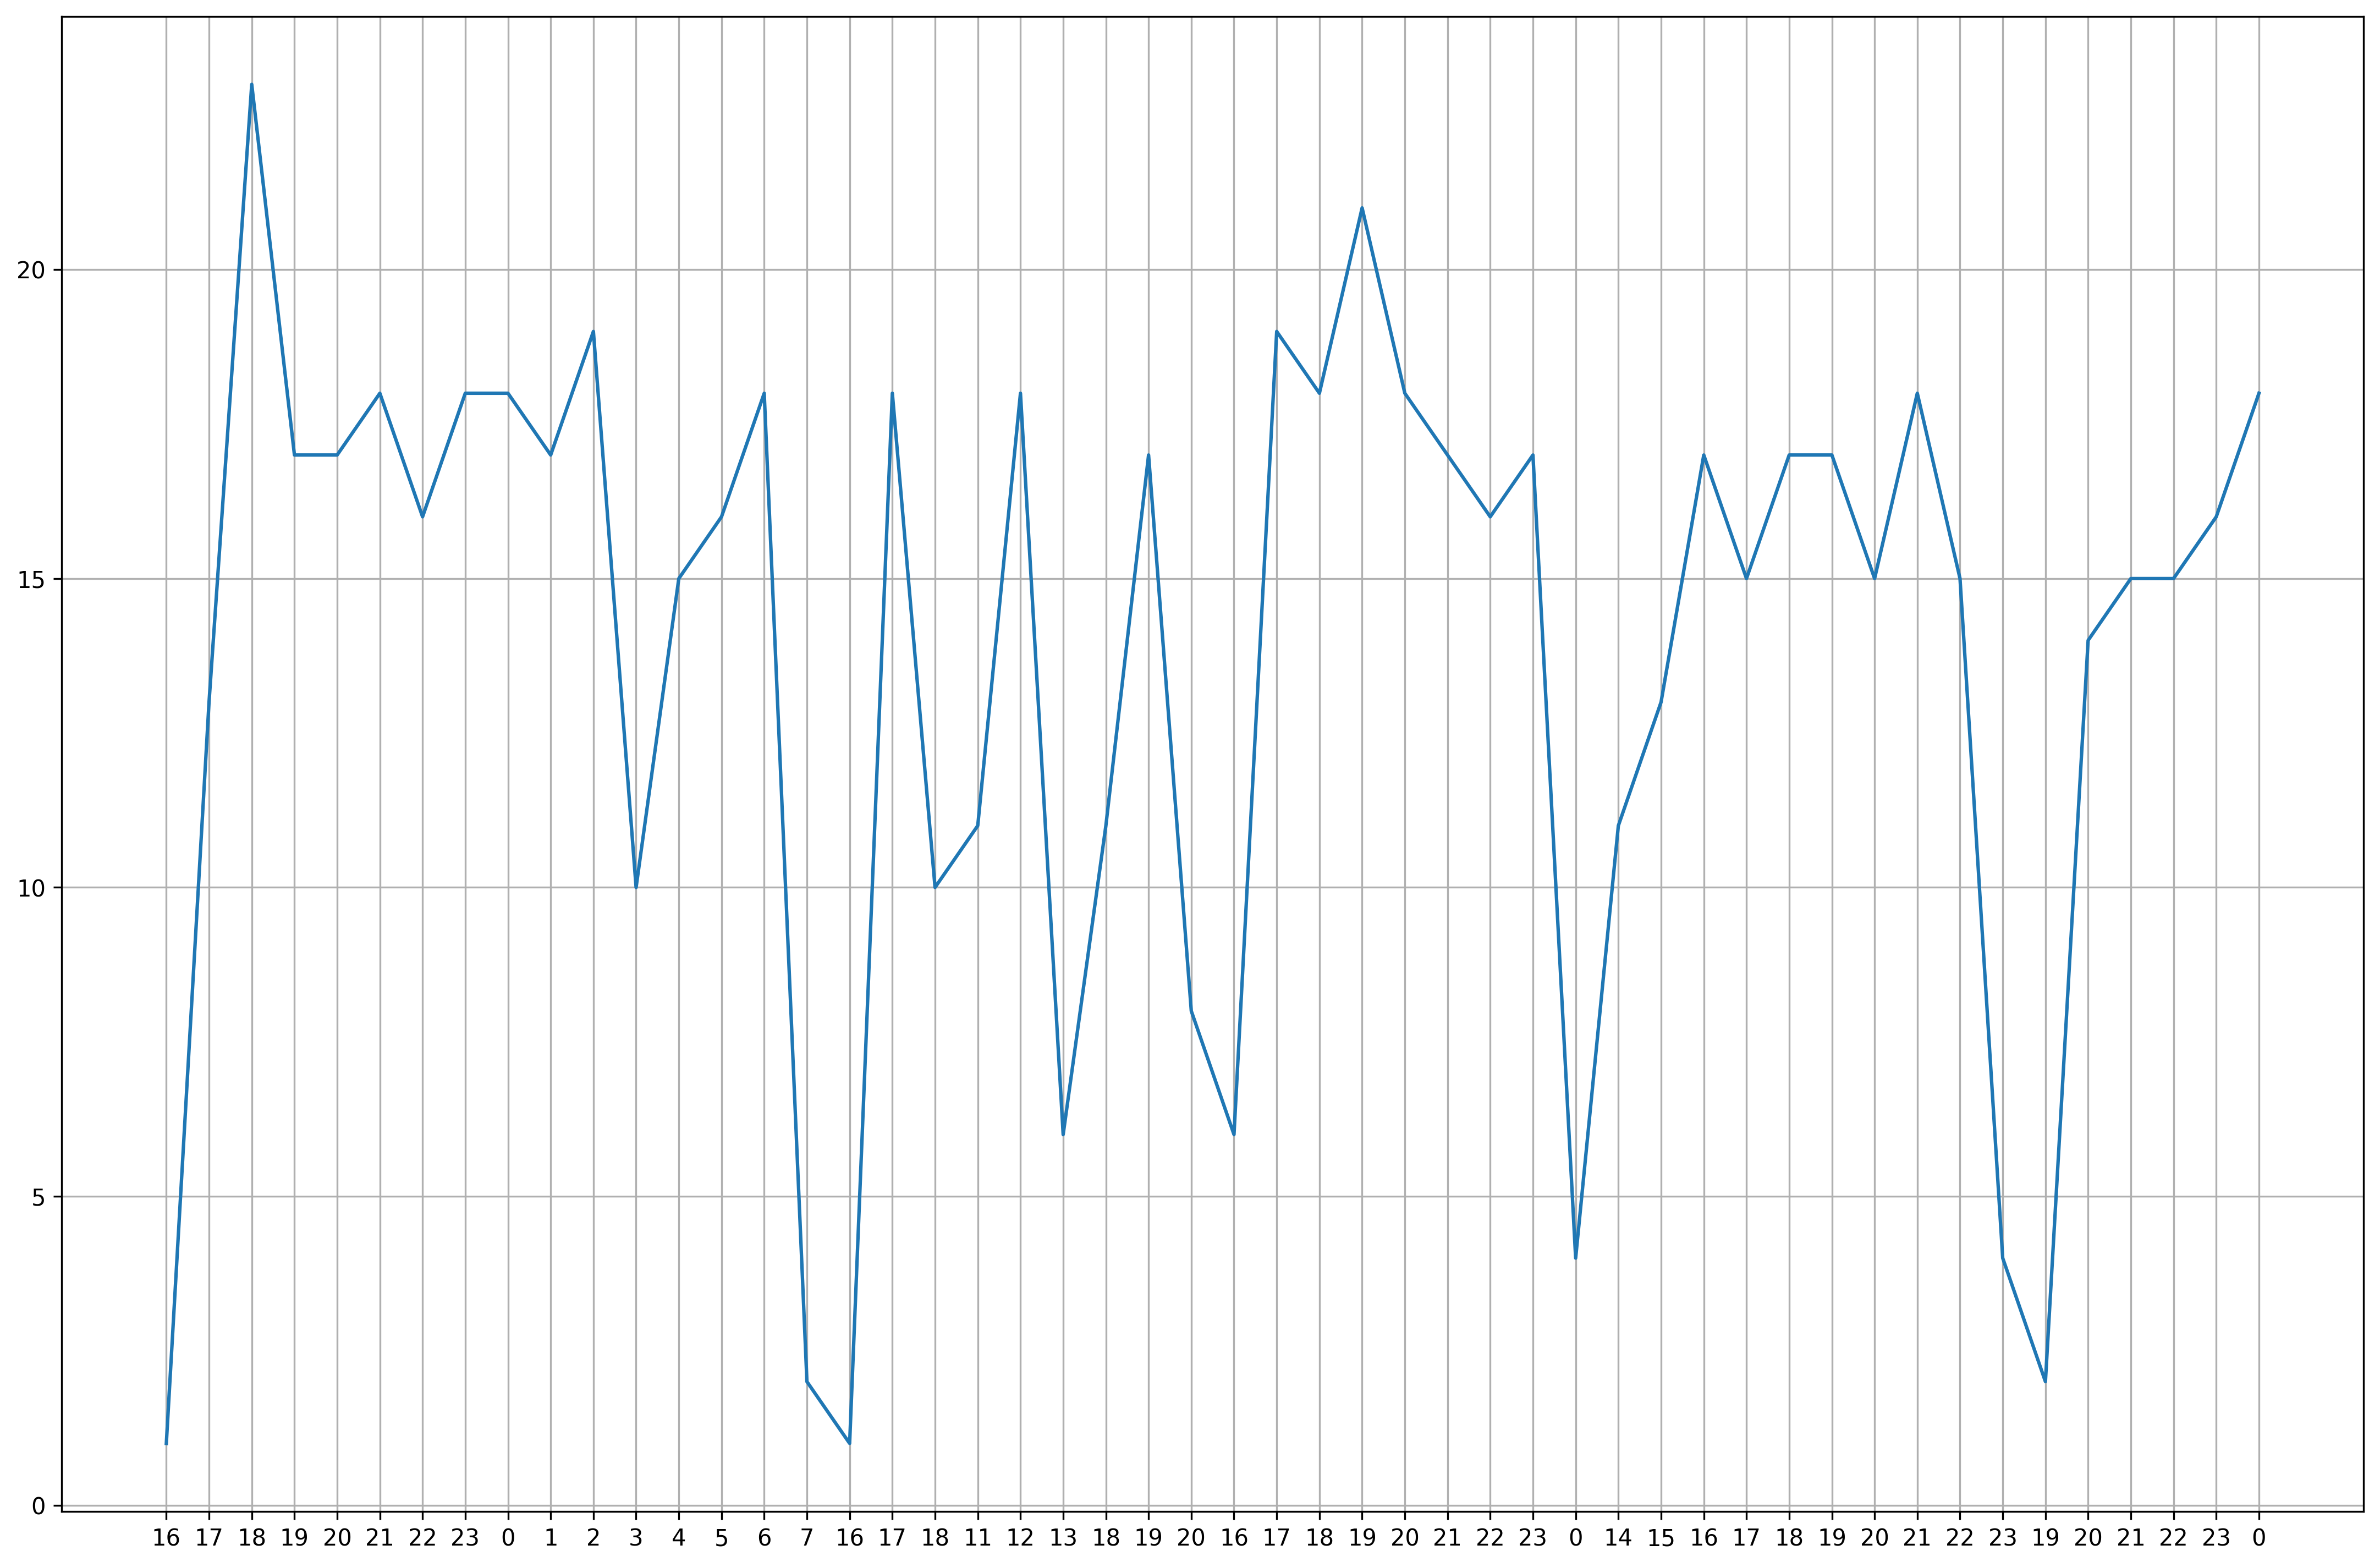

In [235]:
plt.plot(np.arange(len(total_songs_per_hour)), total_songs_per_hour)
plt.xticks(np.arange(len(total_songs_per_hour)), labels=hours)
plt.grid()
plt.show();

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.